<a href="https://colab.research.google.com/github/mhassouna95/BERT_SentimentAnalysis/blob/master/BERT_fine_tunning_for_twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers tensorflow_datasets

In [ ]:
import zipfile
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow_datasets as tfds
from transformers import BertTokenizer
import pickle
import os



# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


Found GPU at: /device:GPU:0


In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13779403661578250548, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7419933276128981810
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7828916553320526914
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2564699036891611720
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



# Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
directory_to_extract_to = '/content/drive/My Drive/'
with zipfile.ZipFile('/content/drive/My Drive/trainingandtestdata.zip', 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
#read in csv
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset_path = '/content/drive/My Drive/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(dataset_path, encoding = DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df = df[['target','text']]
# Replacing the class value from 4 to 1.
df['target'] = df['target'].replace(4,1)

In [ ]:
#extract text and label
text, target = list(df['text']), list(df['target'])

In [ ]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.groupby('target').count()

,text
target,
0,800000
1,800000


# Preprocessing and Tokenization

preprocessing method to remove hashtags and clean the data. Copied from https://www.kaggle.com/stoicstatic/twitter-sentiment-analysis-for-beginners

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']



In [ ]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [ ]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

encoded {'input_ids': [101, 1038, 2721, 14154, 2497, 1038, 2721, 2050, 1038, 2721, 14154, 2497, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Encoding train and test dataset

In [ ]:
#load preprocessed data
with open("/content/drive/My Drive/text.dat", "rb") as f:
    processedtext = pickle.load(f)
with open("/content/drive/My Drive/target.dat", "rb") as f:
    target = pickle.load(f)

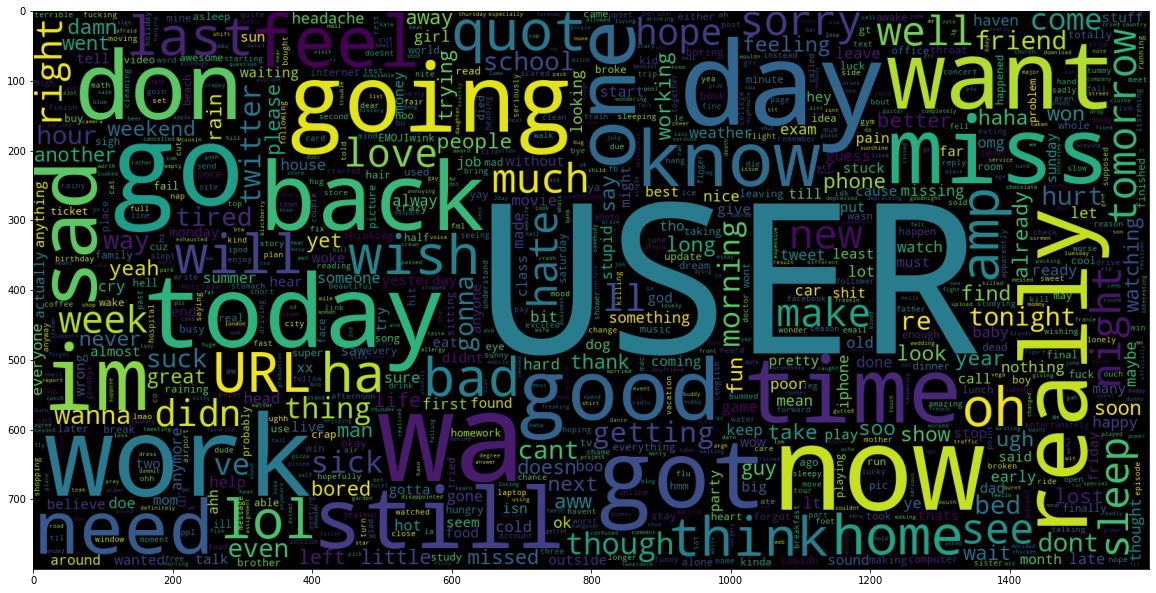

In [ ]:
#negative wordcloud
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

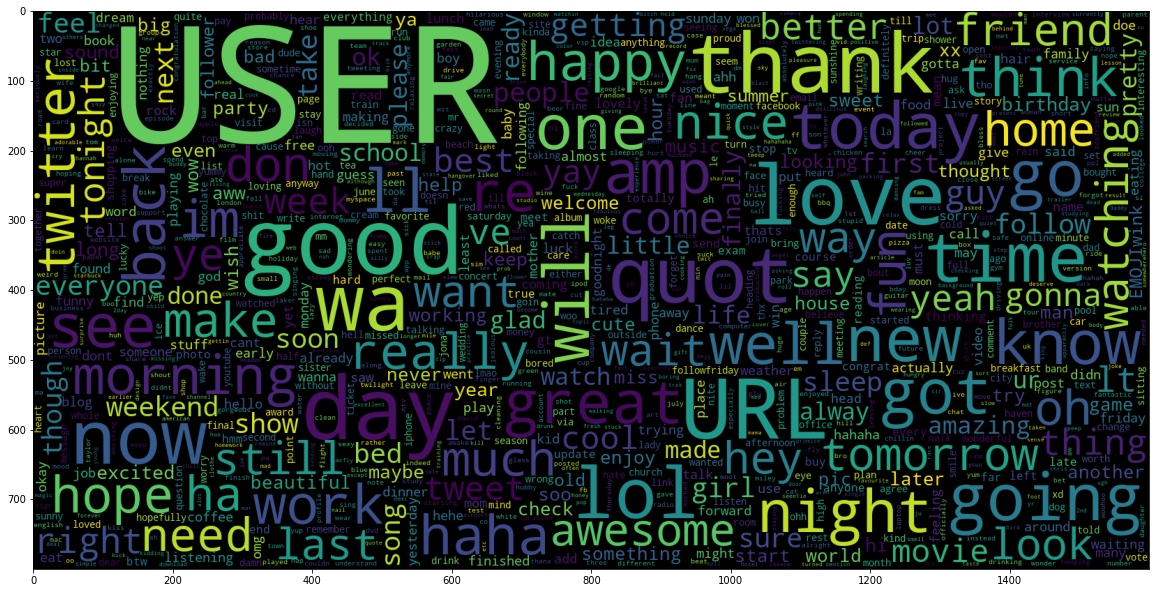

In [ ]:
#positive wordcloud
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [ ]:
print("Maximum length of tweet: ",len(max(processedtext, key=len)))

Maximum length of tweet:  194


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [ ]:
# can be up to 512 for BERT
max_length = 280 # max tweet length


In [ ]:
def convert_example_to_feature(tweet):
  
  return tokenizer.encode_plus(tweet, 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
                truncation=True
              )


When we will now iterate over again we can apply the `encode` function for each item.

In [ ]:
def encode_examples(ds, limit=-1):

  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  #label_list = []

  if (limit > 0):
      ds = ds.take(limit)
    
  for tweet in ds:

    bert_input = convert_example_to_feature(tweet)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    #label_list.append([label])

  return input_ids_list, attention_mask_list, token_type_ids_list

In [ ]:
input_ids_list, attention_mask_list, token_type_ids_list = encode_examples(processedtext)
label_list = target



In [ ]:
len(input_ids_list)

In [ ]:
#save
with open("/content/drive/My Drive/twitter/input_ids_list.dat", "wb") as f:
    pickle.dump(input_ids_list, f)
with open("/content/drive/My Drive/twitter/token_type_ids_list.dat", "wb") as f:
    pickle.dump(token_type_ids_list, f)
with open("/content/drive/My Drive/twitter/attention_mask_list.dat", "wb") as f:
    pickle.dump(attention_mask_list, f)
with open("/content/drive/My Drive/twitter/label_list.dat", "wb") as f:
    pickle.dump(label_list, f)

# Data loading from drive, creating Train and Test set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load ready data
with open("/content/drive/My Drive/twitter/input_ids_list.dat", "rb") as f:
    input_ids_list = pickle.load(f)
#with open("/content/drive/My Drive/twitter/token_type_ids_list.dat", "rb") as f:
#    token_type_ids_list = pickle.load(f)
#with open("/content/drive/My Drive/twitter/attention_mask_list.dat", "rb") as f:
#    attention_mask_list = pickle.load(f)
with open("/content/drive/My Drive/twitter/label_list.dat", "rb") as f:
    label_list = pickle.load(f)

In [ ]:
len(input_ids_list)

1600000

In [ ]:
#only need input ids
X_train, X_test, y_train, y_test = train_test_split(input_ids_list, label_list, test_size = 0.05, random_state=90014)

# Model initialization

We will use already prepared TensorFlow models from transformers models. You can just import them from the library and call `from_pretrained` and you will be able to use them 



In [ ]:
# can be up to 512 for BERT
max_length = 280
batch_size = 32

In [ ]:
ds_train_encoded = tf.data.Dataset.from_tensor_slices((X_train[0:50000], y_train[0:50000])).batch(batch_size)


In [ ]:
ds_test_encoded = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf


# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 1


# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparse categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_151', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_151 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


# Fine tunning

## Training

In [ ]:
#load already trained weights
#checkpoint_path = "/content/drive/My Drive/twitter/training_1/cp.ckpt"
#model.load_weights(checkpoint_path)

In [ ]:
checkpoint_path = "/content/drive/My Drive/twitter/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#callback to automatically save the weights to disk after training
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)


In [ ]:
bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs,callbacks=[cp_callback])#validation_data=ds_test_encoded,

16/16 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5380
Epoch 00001: saving model to /content/drive/My Drive/twitter/training_1/cp.ckpt
16/16 [==============================] - 18s 1s/step - loss: 0.6938 - accuracy: 0.5380


## Evaluation

In [ ]:
results = model.evaluate(ds_train_encoded)
print("train loss, train acc:", results)
results = model.evaluate(ds_test_encoded)
print("test loss, test acc:", results)


4167/4167 [==============================] - 655s 157ms/step - loss: 0.0585 - accuracy: 0.9822
train loss, train acc: [0.05853773280978203, 0.982200026512146]
4167/4167 [==============================] - 649s 156ms/step - loss: 0.2039 - accuracy: 0.9279
test loss, test acc: [0.2039407640695572, 0.9279199838638306]


Not that far away from the [current state of the art](https://nlpprogress.com/english/sentiment_analysis.html). 

In [ ]:
test_sentence = "Not bad this movie, can recommend"
max_length_test= 280
bert_input = tokenizer.encode_plus(
                        test_sentence,                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        max_length = max_length_test, # max length of the text that can go to BERT
                        pad_to_max_length = True, # add [PAD] tokens
                        return_attention_mask = False, # add attention mask to not focus on pad tokens
                        truncation=True,
              )

print('encoded', bert_input)

NameError: ignored

In [ ]:
tf.nn.softmax(model.predict([bert_input["input_ids"]]))